In [1]:
from aixi_booster import *
import numpy as np
import pandas as pd
import random

In [2]:
#X = np.array(np.arange(1000),ndmin=2).T
#Y = np.array(np.sin(X/12.),ndmin=2)

In [3]:
np.random.seed(0)
random.seed(0)

In [4]:
#делаем датасет
#Суть датасета: есть зашумлённая синусоида, на которую наложены случайные блуждания. 
#AIXI примерно знает текущее состояние блужданий и немного устаревшие значения этой "синусоиды"
j = 0
X_lst = []
Y_lst = []
X_rec = [0, 0]
k = 0
dk = -0.02
for i in range(5500):
    j += (np.random.rand()-0.5)*6
    dk += (np.random.rand()-0.48)*0.001
    k += dk
    Y_rec = [np.sin(X_rec[0]*0.02 + X_rec[1]*0.0000001) * (1 + np.cos(X_rec[0] * 0.001) * X_rec[1] * 0.1) + k]
    Y_prev = 0
    if len(Y_lst)>5:
        Y_prev = Y_lst[-5][0]
    X_rec = [i, j, dk, Y_prev]
    X_lst.append(X_rec)
    Y_lst.append(Y_rec)
X = np.array(X_lst)
Y = np.array(Y_lst)

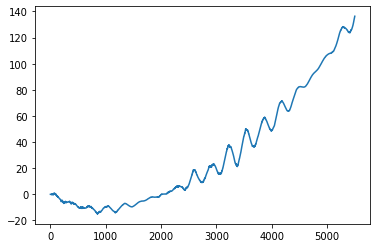

In [5]:
plt.plot(Y)

In [6]:
border = 500
X_train = X[:border,:]
X_test = X[border:,:]
Y_train = Y[:border,:]
Y_test = Y[border:,:]

In [7]:
%%time
#forest_count - число гипотез, то есть размер леса гипотез
#episodes - эпизоды работы AIXI. Если в реальной жизни данные - это несколько блоков по несколько записей.
#Причём каждый блок - это последовательность, у которой известно прошлое, но неизвестно будущее и неизвестны другие последовательности.
#Вот эпизоды - это такие последовательности. Например, если у нас данные - это 2 поездки на машине в 10 минут и в 50 минут, то первым эпизодом будут данные из одной поездки, а вторым - из второй.
#sample_part - сколько последовательностей использовать для генерации каждой одной гипотезы
#popsize, maxiter, alpha_count, elitarism, mutation_p - параметры эволюции (мы не будет тупо перебирать гипотезы)
#popsize - размер популяции, maxiter - число поколений, alpha_count - число альфачей (кто размножается), elitarism - число элитариев (кто сохраняется в неизменном виде в следующем поколении) 
#mutation_p - вероятность мутации
#boosting_count - каждая гипотеза сделана по схеме "бустинг". То есть вначале подбираем гипотезу, 
#которая максимально хорошо предсказывает Y, затем гипотезу, которая максимально хорошо исправляет ошибки первой гипотезы и так далее
#boosting_count - это число слоёв в этом "бутерброде"
model = symbolic_regression_multyboosting(size_genom=900, tact_count=30, regularization=1.,postprocessing_prod='lin', postprocessing_learn='lin')
fractor = 15
episodes = []
for i in range(fractor):
    episodes.append([i*int(len(Y)/fractor), (i+1)*int(len(Y)/fractor)])
episodes_train = episodes[:-4]
episodes_test = episodes[-4:]

model.fit(X_train,Y_train,forest_count=20,sample_part=0.8,episodes=episodes,popsize=30, maxiter=3, boosting_count=2, alpha_count=5, elitarism=2, mutation_p=0.02, n_jobs=7)

FOREST NUMBER 0, episodes [[264 297]
 [429 462]
 [264 297]
 [198 231]
 [363 396]
 [ 66  99]
 [363 396]
 [264 297]
 [231 264]
 [ 66  99]
 [ 33  66]
 [363 396]]
p_arr max,min,med,q0.25,q0.75 0.6666666666666666 0.0033821871478015783 0.039132767200938515 0.021907216494974225 0.09453703933584014
iteration 0 y= [0.03285321 0.0350815  0.03571489 0.03582058 0.03586196 0.03633048
 0.03654423 0.03655654 0.03665682 0.03689023 0.03689652 0.03765852]
iteration 1 y= [0.03285321 0.03312027 0.0339662  0.0350815  0.03513766 0.03514914
 0.03558098 0.03571489 0.03582058 0.03586196 0.03611966 0.03620353]
iteration 2 y= [0.03285321 0.03312027 0.03335741 0.0336403  0.0339662  0.03484866
 0.0350815  0.03513766 0.03514914 0.03558098 0.03560624 0.03564832]
iteration final y= [0.03259516 0.03285321 0.03312027 0.03335741 0.0336403  0.0339662
 0.03454752 0.03454752 0.03454752 0.03454752 0.03454752 0.03454752]
NOCOMPILED [  0.           0.           0.           0.           0.
   0.           0.           0.     

BOOST 0 ready. Score 0.03381160375882395.i 0
p_arr max,min,med,q0.25,q0.75 0.6666666666666666 0.0033821871478015783 0.03907586993727895 0.021879021879150577 0.09252094585268358
iteration 0 y= [0.46007909 0.52468164 0.53839576 0.5936756  0.63662825 0.79037857
 0.84591553 0.85270099 0.85469005 0.86063978 0.86464385 0.8696823 ]
iteration 1 y= [0.28652603 0.33721144 0.38514384 0.38926842 0.41535214 0.46007909
 0.47011653 0.51456234 0.51600209 0.51715947 0.51832733 0.52206983]
iteration 2 y= [0.18491597 0.28652603 0.31174291 0.32044068 0.3211348  0.32185482
 0.32211015 0.33706063 0.33721144 0.33777542 0.33816514 0.33819039]
iteration final y= [0.18491597 0.28573478 0.28652603 0.28662187 0.28733411 0.28744634
 0.28744915 0.28756138 0.28756138 0.28756138 0.28756138 0.28756138]
NOCOMPILED [  0.           0.           0.           0.         928.
   0.           0.           0.         411.34901476   0.
   0.           0.         579.           0.           0.
   0.           0.           0.   

selected boosting without linear layer, mse 2.1681921860585156 [2.900010363867714, 2.1681921860585156, 4.6729757106306415, 3.22942713513791, 47.74828641608998, 72.45904811266514]
BOOST 1 ready. Score:0.6079253506707939
err_sum,complexity 2.1380302474528685 265
FOREST NUMBER 1, episodes [[  0  33]
 [297 330]
 [  0  33]
 [ 33  66]
 [132 165]
 [165 198]
 [231 264]
 [297 330]
 [ 99 132]
 [  0  33]
 [330 363]
 [396 429]]
p_arr max,min,med,q0.25,q0.75 0.6666666666666666 0.0033821871478015783 0.0390395601041216 0.021879021879150577 0.09009975640921442
iteration 0 y= [0.03597671 0.03621657 0.03661963 0.03663918 0.0369535  0.03730945
 0.03780802 0.03792376 0.03916942 0.03981271 0.03984457 0.04183243]
iteration 1 y= [0.03597671 0.03621657 0.03639384 0.03661963 0.03663918 0.03692463
 0.0369535  0.03701386 0.03701386 0.03701386 0.03701386 0.03701386]
iteration 2 y= [0.03597671 0.03621657 0.03639384 0.03661963 0.03663918 0.03664237
 0.03692463 0.0369535  0.03701386 0.03701386 0.03701386 0.03701386]

BOOST 0 ready. Score 0.026175055290764422.i 0
p_arr max,min,med,q0.25,q0.75 0.6666666666666666 0.0032930845226125135 0.03900325027096425 0.021857923497377047 0.08733624454192139
iteration 0 y= [0.56768366 0.58335076 0.684049   0.72542793 0.74088547 0.76990099
 0.77176242 0.78394818 0.79808106 0.80135918 0.80527172 0.81330076]
iteration 1 y= [0.53524634 0.56768366 0.57902441 0.58298881 0.58335076 0.58397646
 0.5849397  0.58507074 0.58538499 0.58618185 0.58709936 0.58756793]
iteration 2 y= [0.31596494 0.42268181 0.4708226  0.51085601 0.51112276 0.53480209
 0.53524634 0.53623307 0.53951514 0.56131955 0.56768366 0.56843562]
iteration final y= [0.30887109 0.31596494 0.31783363 0.32766644 0.32998126 0.33340568
 0.40317597 0.40562406 0.40604774 0.4061169  0.42268181 0.42417732]
NOCOMPILED [  0.         457.68696544 924.           0.           0.
 924.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
 733.           0.           0.  

selected linear model 1, mse 1.8243344490359075 [2.2288805962414138, 2.17644940649526, 2.169816262737332, 2.191858628730576, 1.8243344490359075, 1.8561785288431942]
BOOST 1 ready. Score:0.7172916163258494
err_sum,complexity 2.989370513697809 273
FOREST NUMBER 2, episodes [[396 429]
 [462 495]
 [297 330]
 [396 429]
 [ 99 132]
 [231 264]
 [198 231]
 [165 198]
 [264 297]
 [363 396]
 [198 231]
 [363 396]]
p_arr max,min,med,q0.25,q0.75 0.6666666666666666 0.0032930845226125135 0.03895423766659499 0.021850899743059125 0.08472545621953959
iteration 0 y= [0.03907644 0.04123998 0.04139196 0.0435325  0.04587635 0.04670921
 0.04679968 0.04683801 0.04694745 0.04709967 0.04798935 0.04873944]
iteration 1 y= [0.03907644 0.04123998 0.04139196 0.04183762 0.04188333 0.04190216
 0.04209295 0.04210137 0.04236512 0.04236512 0.04236512 0.04236512]
iteration 2 y= [0.03907644 0.0408389  0.04123998 0.04139196 0.04183762 0.04188333
 0.04190216 0.04209295 0.04210137 0.04236512 0.04236512 0.04236512]
iteration fin

BOOST 0 ready. Score 0.0346734202527991.i 0
p_arr max,min,med,q0.25,q0.75 0.6666666666666666 0.0032930845226125135 0.038786647219938464 0.021850899743059125 0.08278075081499256
iteration 0 y= [0.62356403 0.65437092 0.6807435  0.70853505 0.71269556 0.71396999
 0.71725929 0.72577505 0.73577125 0.74446061 0.76948998 0.7738265 ]
iteration 1 y= [0.62356403 0.65437092 0.65591749 0.65592535 0.65725532 0.65742928
 0.65765375 0.65872838 0.65940459 0.66145846 0.66371421 0.66371421]
iteration 2 y= [0.62356403 0.63763099 0.65437092 0.65445066 0.65591749 0.65592535
 0.65597866 0.6559955  0.65618349 0.65659381 0.65666048 0.65725532]
iteration final y= [0.62356403 0.63763099 0.65437092 0.65445066 0.65591749 0.65592535
 0.65597866 0.6559955  0.65618349 0.65659381 0.65666048 0.65725532]
NOCOMPILED [868. 760. 923. 608. 602. 923. 954. 943. 953. 805. 563. 674. 749. 911.
 989. 954. 674. 969. 628. 531. 628. 961. 908. 943. 961. 708. 743. 783.
 602. 911. 943. 913. 789. 632. 746. 961. 708. 769. 769. 953. 708. 

COMPILED [57, 57, 57, 33.0, 5.0, 12.0, 17.0, 21.0, 30.0, 21.0, 30.0, 21.0, 30.0, 17.0, 16.0, 57, 57, 17.0, 16.0, 57, 57, 57, 33.0, 5.0, 12.0, 17.0, 21.0, 30.0, 21.0, 30.0, 21.0, 30.0, 13.0, 57, 21.0, 30.0, 21.0, 30.0, 21.0, 30.0, 2.0, 24.0, 21.0, 30.0, 21.0, 30.0, 21.0, 30.0, 21.0, 30.0, 21.0, 30.0, 21.0, 30.0, 21.0, 30.0, 21.0, 30.0, 21.0, 30.0, 21.0, 30.0, 21.0, 30.0, 44.0, 21.0, 30.0, 21.0, 30.0, 33.0, 33.0, 57, 21.0, 30.0, 21.0, 30.0, 21.0, 30.0, 44.0, 21.0, 30.0, 21.0, 30.0, 33.0, 33.0, 21.0, 30.0, 21.0, 30.0, 21.0, 30.0, 33.0, 5.0, 12.0, 17.0, 21.0, 30.0, 21.0, 30.0, 21.0, 30.0, 16.0, 32.0, 57, 57, 33.0, 5.0, 12.0, 17.0, 21.0, 30.0, 21.0, 30.0, 21.0, 30.0, 40.0, 57, 21.0, 30.0, 21.0, 30.0, 21.0, 30.0, 21.0, 30.0, 21.0, 30.0, 40.0, 57, 21.0, 30.0, 21.0, 30.0, 21.0, 30.0, 21.0, 30.0, 21.0, 30.0, 29.0, 33.0, 5.0, 12.0, 17.0, 21.0, 30.0, 21.0, 30.0, 21.0, 30.0, 16.0, 32.0, 33.0, 5.0, 12.0, 17.0, 21.0, 30.0, 21.0, 30.0, 21.0, 30.0, 13.0, 57, 57, 29.0, 57, 21.0, 30.0, 21.0, 30.0, 21.0,

selected linear model 1000, mse 1.8535884179450035 [2.83866018569334, 1.9113302140043464, 1.8839332662495123, 1.8535884179450035, 2.9257386384738977, 3.1676941659456954]
BOOST 1 ready. Score:0.9509202992105272
err_sum,complexity 22.433423004590964 255
FOREST NUMBER 3, episodes [[ 33  66]
 [ 99 132]
 [429 462]
 [  0  33]
 [330 363]
 [330 363]
 [429 462]
 [  0  33]
 [264 297]
 [  0  33]
 [ 66  99]
 [297 330]]
p_arr max,min,med,q0.25,q0.75 0.6666666666666666 0.0032930845226125135 0.038610038610231656 0.021850899743059125 0.0810055865924581
iteration 0 y= [0.05646323 0.05778427 0.05946759 0.0599136  0.0642985  0.06448551
 0.06465206 0.06504549 0.06522751 0.0653792  0.06552713 0.06557956]
iteration 1 y= [0.05402387 0.05562497 0.05646323 0.05668441 0.05778427 0.05813251
 0.05853655 0.05876584 0.0591211  0.05927562 0.05940636 0.05946759]
iteration 2 y= [0.05311036 0.0533645  0.05402387 0.05462328 0.0547299  0.05540892
 0.05561357 0.05562497 0.05570914 0.05613843 0.05636571 0.05643866]
iterati

BOOST 0 ready. Score 0.03799171329003318.i 0
p_arr max,min,med,q0.25,q0.75 0.6666666666666666 0.0032930845226125135 0.03852337373248549 0.021850899743059125 0.0791708043697911
iteration 0 y= [0.44712882 0.4860874  0.49652562 0.50850352 0.52057372 0.54305327
 0.55777661 0.60781676 0.6189191  0.63014222 0.67766163 0.69876113]
iteration 1 y= [0.36711776 0.401381   0.40291171 0.44712882 0.48431972 0.4860874
 0.48609301 0.48615931 0.4869039  0.48747293 0.48747293 0.48747293]
iteration 2 y= [0.3480787  0.36116202 0.36711776 0.38363408 0.38402129 0.38526708
 0.38552521 0.40025867 0.40045507 0.40101344 0.401381   0.40204318]
iteration final y= [0.3399947  0.3480787  0.3580833  0.35956549 0.36035674 0.36055948
 0.36067941 0.36116202 0.36207672 0.36210758 0.36239378 0.36249479]
NOCOMPILED [  0.           0.           0.         928.           0.
   0.           0.           0.           0.           0.
 708.57122056   0.           0.         906.           0.
   0.           0.           0.     

COMPILED [21.0, 30.0, 21.0, 30.0, 21.0, 30.0, 44.0, 21.0, 30.0, 21.0, 30.0, 33.0, 33.0, 21.0, 30.0, 21.0, 30.0, 21.0, 30.0, 33.0, 5.0, 12.0, 17.0, 21.0, 30.0, 21.0, 30.0, 21.0, 30.0, 16.0, 32.0, 5.0, 39.0, 21.0, 30.0, 21.0, 30.0, 21.0, 30.0, 21.0, 30.0, 21.0, 30.0, 44.0, 21.0, 30.0, 21.0, 30.0, 33.0, 33.0, 57, 57, 29.0, 29.0, 33.0, 5.0, 12.0, 17.0, 21.0, 30.0, 21.0, 30.0, 21.0, 30.0, 16.0, 32.0, 33.0, 5.0, 12.0, 17.0, 21.0, 30.0, 21.0, 30.0, 21.0, 30.0, 13.0, 33.0, 5.0, 12.0, 17.0, 21.0, 30.0, 21.0, 30.0, 21.0, 30.0, 16.0, 32.0, 21.0, 30.0, 21.0, 30.0, 21.0, 30.0, 21.0, 30.0, 21.0, 30.0, 21.0, 30.0, 44.0, 21.0, 30.0, 21.0, 30.0, 33.0, 33.0, 21.0, 30.0, 21.0, 30.0, 21.0, 30.0, 44.0, 21.0, 30.0, 21.0, 30.0, 33.0, 33.0, 57, 21.0, 30.0, 21.0, 30.0, 21.0, 30.0, 44.0, 21.0, 30.0, 21.0, 30.0, 33.0, 33.0, 21.0, 30.0, 21.0, 30.0, 21.0, 30.0, 33.0, 5.0, 12.0, 17.0, 21.0, 30.0, 21.0, 30.0, 21.0, 30.0, 16.0, 32.0, 5.0, 39.0, 21.0, 30.0, 21.0, 30.0, 21.0, 30.0, 21.0, 30.0, 21.0, 30.0, 44.0, 21.0, 3

selected linear model 1000, mse 2.962325228442779 [3.252209514119403, 3.3995143267653987, 3.723170428485426, 2.962325228442779, 6.026963100637797, 6.225962768151848]
BOOST 1 ready. Score:0.7099797627188956
err_sum,complexity 9.014583337635287 290
FOREST NUMBER 4, episodes [[132 165]
 [264 297]
 [ 99 132]
 [396 429]
 [396 429]
 [330 363]
 [429 462]
 [363 396]
 [ 33  66]
 [165 198]
 [132 165]
 [429 462]]
p_arr max,min,med,q0.25,q0.75 0.6666666666666666 0.0032930845226125135 0.03829321663030635 0.021850899743059125 0.07691177191040757
iteration 0 y= [0.03913584 0.04118261 0.04217977 0.04307107 0.04342354 0.04367053
 0.04372168 0.04378864 0.04631849 0.04658088 0.04871884 0.04882801]
iteration 1 y= [0.03913584 0.04014454 0.04097925 0.04118261 0.04210166 0.04217977
 0.04262985 0.04280948 0.04289855 0.04307107 0.04316468 0.04342354]
iteration 2 y= [0.03913584 0.03947856 0.04014454 0.04097925 0.04118261 0.04150293
 0.04190942 0.04210166 0.04217977 0.0422766  0.0422766  0.0422766 ]
iteration fi

BOOST 0 ready. Score 0.0428387240828261.i 0
p_arr max,min,med,q0.25,q0.75 0.6666666666666666 0.0032930845226125135 0.0381326781327844 0.02184326526069335 0.07458891980806982
iteration 0 y= [0.39459095 0.40862001 0.44869588 0.53108648 0.55209421 0.55762055
 0.5673858  0.59453446 0.61439523 0.62442901 0.6828303  0.68533611]
iteration 1 y= [0.27275668 0.27389304 0.39459095 0.40298585 0.40329168 0.4043074
 0.40444769 0.40862001 0.40978443 0.41004257 0.41093763 0.41093763]
iteration 2 y= [0.26179455 0.27275668 0.27389304 0.27426725 0.2745917  0.27476005
 0.27492329 0.27504727 0.27504727 0.27504727 0.27504727 0.27504727]
iteration final y= [0.22233077 0.22255762 0.24118347 0.26179455 0.27126781 0.27215027
 0.27275668 0.27380045 0.27389304 0.27426725 0.2745917  0.27476005]
NOCOMPILED [638.         801.           0.           0.           0.
   0.           0.         250.28326685 944.         745.
   0.           0.           0.           0.           0.
   0.           0.           0.       

selected boosting with linear layer, mse 1.8056068536398662 [1.8056068536398662, 1.8553912444949945, 4.528251428425006, 5.7909811210476985, 2.9325621132156527, 2.869644129091739]
BOOST 1 ready. Score:0.8176050700954056
err_sum,complexity 5.243011403894748 276
FOREST NUMBER 5, episodes [[132 165]
 [198 231]
 [462 495]
 [165 198]
 [462 495]
 [297 330]
 [429 462]
 [330 363]
 [297 330]
 [132 165]
 [198 231]
 [231 264]]
p_arr max,min,med,q0.25,q0.75 0.6666666666666666 0.0032930845226125135 0.03807814407820934 0.021850899743059125 0.0741819382399817
iteration 0 y= [0.02168128 0.02192053 0.02198315 0.02314281 0.02383061 0.02383882
 0.02398602 0.02409662 0.02436835 0.02486082 0.02489086 0.02490084]
iteration 1 y= [0.01959322 0.02168128 0.02192053 0.02198315 0.02289135 0.02314281
 0.02365704 0.02383061 0.02383882 0.02390145 0.02398602 0.0240583 ]
iteration 2 y= [0.01959322 0.0198404  0.02168128 0.02192053 0.02198315 0.02213928
 0.02221974 0.02274679 0.02289135 0.02306677 0.02314281 0.02318683]


BOOST 0 ready. Score 0.02317739771622433.i 0
p_arr max,min,med,q0.25,q0.75 0.6666666666666666 0.0032930845226125135 0.03790412486075809 0.021841870327090583 0.07366229624402108
iteration 0 y= [0.45882966 0.47460683 0.52185976 0.52887819 0.54357438 0.58666652
 0.59150224 0.63366731 0.67320699 0.68813827 0.6887184  0.69549647]
iteration 1 y= [0.38273456 0.38335465 0.42655244 0.42669509 0.45882966 0.47460683
 0.47631557 0.47690761 0.47753051 0.47755296 0.47760627 0.47817327]
iteration 2 y= [0.27294481 0.27466479 0.32127328 0.34419928 0.34862609 0.38273456
 0.38331818 0.38335465 0.38398877 0.38821665 0.40700254 0.40826517]
iteration final y= [0.26514049 0.26995894 0.27124774 0.27221014 0.27294481 0.27298704
 0.27305764 0.27323441 0.27323441 0.27323441 0.27323441 0.27323441]
NOCOMPILED [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 5.40749611e+02 0.00000000e+00 9.83000000e+02 0.00000000e+00
 9.12000000e+02 7.49000000e+02 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.0000000

selected linear model 0.05, mse 1.976493574079947 [2.2393781565337982, 2.519575255161167, 2.1124976911250335, 2.0560487879482903, 1.978591008158305, 1.976493574079947]
BOOST 1 ready. Score:0.8347048925411376
err_sum,complexity 4.639370934802913 283
FOREST NUMBER 6, episodes [[ 99 132]
 [ 99 132]
 [264 297]
 [429 462]
 [165 198]
 [330 363]
 [429 462]
 [132 165]
 [264 297]
 [330 363]
 [132 165]
 [264 297]]
p_arr max,min,med,q0.25,q0.75 0.6666666666666666 0.0038138825324942793 0.0377472759439528 0.021794871794999997 0.07311724433064444
iteration 0 y= [0.01914845 0.02179942 0.0221957  0.02332911 0.02389515 0.0246224
 0.02467637 0.02470861 0.02492367 0.0265468  0.02661625 0.0269739 ]
iteration 1 y= [0.01914845 0.02179942 0.0221957  0.02220653 0.02261695 0.0232603
 0.02332911 0.02336059 0.02379698 0.0237977  0.02388475 0.02389515]
iteration 2 y= [0.01914845 0.02179942 0.0221957  0.02220653 0.02261695 0.02271511
 0.02272815 0.02285012 0.0232603  0.02332911 0.02336059 0.02364724]
iteration fin

BOOST 0 ready. Score 0.022997396907962205.i 0
p_arr max,min,med,q0.25,q0.75 0.6666666666666666 0.0038138825324942793 0.037567084078890874 0.021791767554600484 0.07255520504747634
iteration 0 y= [0.5495181  0.70566578 0.7300858  0.73240059 0.73687629 0.73707963
 0.74062611 0.74921384 0.75921425 0.76609559 0.77297238 0.80136656]
iteration 1 y= [0.5495181  0.66134345 0.70566578 0.70661976 0.70831449 0.7086119
 0.70917773 0.71318941 0.71336299 0.71485025 0.71550887 0.71550887]
iteration 2 y= [0.5495181  0.59789536 0.66134345 0.66219923 0.66219923 0.66219923
 0.66219923 0.66219923 0.66219923 0.66219923 0.66219923 0.66219923]
iteration final y= [0.54369093 0.5495181  0.58179066 0.58233388 0.59678636 0.59789536
 0.59999412 0.60006988 0.60057774 0.60058054 0.60144474 0.60159906]
NOCOMPILED [   0.            0.         1003.            0.            0.
    0.            0.          833.          232.13329572    0.
  599.            0.          639.            0.            0.
  976.          70

selected boosting with linear layer, mse 2.8082410047555846 [2.8082410047555846, 2.966635529154648, 4.346852626184158, 3.8096622205926645, 4.96327592245407, 5.018274928564752]
BOOST 1 ready. Score:0.8317471070529495
err_sum,complexity 5.542881489547163 233
FOREST NUMBER 7, episodes [[231 264]
 [264 297]
 [363 396]
 [363 396]
 [132 165]
 [  0  33]
 [231 264]
 [  0  33]
 [165 198]
 [132 165]
 [  0  33]
 [429 462]]
p_arr max,min,med,q0.25,q0.75 0.6666666666666666 0.0038138825324942793 0.03737688820103373 0.0217669654290653 0.07193553966811318
iteration 0 y= [0.01858234 0.01912517 0.0212722  0.02205995 0.0226633  0.02377564
 0.0242012  0.02428536 0.02445353 0.02458149 0.02464624 0.02539831]
iteration 1 y= [0.01858234 0.01912517 0.02090831 0.0212722  0.02163102 0.02171519
 0.02174547 0.02205995 0.02211482 0.02237152 0.0226633  0.02327916]
iteration 2 y= [0.0155704  0.01858234 0.01912517 0.01984821 0.02005578 0.02007333
 0.02007333 0.02007333 0.02007333 0.02007333 0.02007333 0.02007333]
iter

BOOST 0 ready. Score 0.01653215511102219.i 0
p_arr max,min,med,q0.25,q0.75 0.6666666666666666 0.0038138825324942793 0.03712296983770302 0.0217669654290653 0.07162118258629142
iteration 0 y= [0.8637726  0.87871696 0.93713627 0.94033517 0.94558365 0.97230753
 0.9742103  0.98895096 0.99044182 0.9905142  0.99234417 0.99257009]
iteration 1 y= [0.8637726  0.86608618 0.86608618 0.86608618 0.86608618 0.86608618
 0.86608618 0.86608618 0.86608618 0.86608618 0.86608618 0.86608618]
iteration 2 y= [0.8637726  0.86608618 0.86608618 0.86608618 0.86608618 0.86608618
 0.86608618 0.86608618 0.86608618 0.86608618 0.86608618 0.86608618]
iteration final y= [0.8637726  0.86608618 0.86608618 0.86608618 0.86608618 0.86608618
 0.86608618 0.86608618 0.86608618 0.86608618 0.86608618 0.86608618]
NOCOMPILED [ 650.  632.  808.  643.  744.  694.  525.  611.  883.  554.  629.  607.
  944.  628.  611.  743.  650.  611.  640.  993.  859.  744.  940.  747.
  840.  801.  766.  628.  984.  697.  618.  694.  694.  694.  96

selected linear model 1000, mse 1.967208838831336 [8.507725518791101, 2.7836741847582562, 2.089227496919972, 1.967208838831336, 4.7390056890631325, 5.179079069130106]
BOOST 1 failed. Score:1.0253403384605406
err_sum,complexity 25.261502032803676 89
FOREST NUMBER 8, episodes [[132 165]
 [ 33  66]
 [297 330]
 [  0  33]
 [ 33  66]
 [462 495]
 [363 396]
 [264 297]
 [330 363]
 [ 99 132]
 [ 33  66]
 [132 165]]
p_arr max,min,med,q0.25,q0.75 0.6666666666666666 0.0038138825324942793 0.037043648786849695 0.021732189460952976 0.07072261072294017
iteration 0 y= [0.01752717 0.01803987 0.01908988 0.01959649 0.01973213 0.02000399
 0.02007393 0.02013193 0.02020117 0.02029325 0.02036531 0.02039382]
iteration 1 y= [0.01752717 0.01803987 0.01908988 0.01959649 0.01973213 0.01998466
 0.02000399 0.02007393 0.02007605 0.02011376 0.02013193 0.02020117]
iteration 2 y= [0.01752717 0.01803987 0.01842905 0.01908988 0.01924918 0.01959649
 0.01973213 0.01998466 0.0199854  0.02000399 0.02003424 0.02006992]
iteration

BOOST 0 ready. Score 0.025457427229533668.i 0
p_arr max,min,med,q0.25,q0.75 0.6666666666666666 0.0038138825324942793 0.03687445127313433 0.021711366539080457 0.07055214723957055
iteration 0 y= [0.42769999 0.47520722 0.48893399 0.5049433  0.52618823 0.61225063
 0.65539101 0.66230593 0.66231569 0.67287448 0.67859741 0.7005999 ]
iteration 1 y= [0.42769999 0.47520722 0.47738865 0.47758158 0.47880212 0.4849397
 0.48512769 0.48893399 0.4980224  0.5049433  0.50895052 0.50895052]
iteration 2 y= [0.42769999 0.44121182 0.44544826 0.47520722 0.47738865 0.47758158
 0.47880212 0.4805761  0.48116669 0.48464774 0.4849397  0.48512769]
iteration final y= [0.41084323 0.42769999 0.43226802 0.43503036 0.43845694 0.43845694
 0.43845694 0.43845694 0.43845694 0.43845694 0.43845694 0.43845694]
NOCOMPILED [   0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.
  243.9023389     0.            0.            0.            0.
    0.            0

selected boosting with linear layer, mse 1.3164062098653917 [1.3164062098653917, 1.731575912020488, 1.7881770749097459, 1.8623977678768309, 1.4099813992476304, 1.446717538013435]
BOOST 1 ready. Score:0.8314797181086436
err_sum,complexity 4.967751722472785 236
FOREST NUMBER 9, episodes [[ 66  99]
 [165 198]
 [429 462]
 [429 462]
 [462 495]
 [ 66  99]
 [330 363]
 [264 297]
 [231 264]
 [231 264]
 [462 495]
 [396 429]]
p_arr max,min,med,q0.25,q0.75 0.6666666666666666 0.0038138825324942793 0.03683281569042034 0.021711366539080457 0.0701754385968421
iteration 0 y= [0.01630058 0.01651253 0.01766725 0.01798985 0.01935696 0.02016483
 0.02038338 0.02060769 0.02074349 0.02109746 0.02149058 0.02200152]
iteration 1 y= [0.01630058 0.01651253 0.01749112 0.01766725 0.01773052 0.01778004
 0.01798985 0.01801011 0.0181293  0.01814528 0.01829916 0.01833032]
iteration 2 y= [0.0148808  0.01630058 0.01646663 0.01651253 0.01687666 0.01713761
 0.01713761 0.01713761 0.01713761 0.01713761 0.01713761 0.01713761]


BOOST 0 ready. Score 0.01920612344121369.i 0
p_arr max,min,med,q0.25,q0.75 0.6666666666666666 0.0038080731150799694 0.036706869428474044 0.02168949771700913 0.07005137218612774
iteration 0 y= [0.63602075 0.69398473 0.70010027 0.70064735 0.70362933 0.71741143
 0.72623486 0.77271722 0.7746182  0.78150551 0.81935968 0.84231239]
iteration 1 y= [0.63602075 0.69398473 0.69561212 0.69564031 0.69645106 0.69671481
 0.69709598 0.69802794 0.69963569 0.69994433 0.70010027 0.70017964]
iteration 2 y= [0.46739235 0.47667688 0.63602075 0.69218639 0.69398473 0.69502387
 0.69524175 0.69528664 0.69528664 0.69528664 0.69528664 0.69528664]
iteration final y= [0.41077608 0.41384076 0.43260726 0.4354804  0.4383676  0.44792717
 0.44959942 0.46739235 0.47418986 0.47667688 0.47852032 0.47852032]
NOCOMPILED [ 533.            0.            0.          920.            0.
    0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.
    0.            0

selected boosting with linear layer, mse 1.4982599550614533 [1.4982599550614533, 1.7677391133429468, 2.2063468484774176, 1.7365713823962217, 3.025521574391427, 3.055420513235505]
BOOST 1 ready. Score:0.9046119686008796
err_sum,complexity 1.871156098184049 211
FOREST NUMBER 10, episodes [[231 264]
 [297 330]
 [429 462]
 [264 297]
 [ 33  66]
 [363 396]
 [429 462]
 [165 198]
 [ 33  66]
 [ 66  99]
 [264 297]
 [264 297]]
p_arr max,min,med,q0.25,q0.75 0.6666666666666666 0.0038080731150799694 0.036681491650471125 0.021683673469515302 0.06907452907484521
iteration 0 y= [0.01806606 0.01891269 0.01916852 0.02011827 0.02026574 0.02102916
 0.02125577 0.0216496  0.02220627 0.02243214 0.02253077 0.02258778]
iteration 1 y= [0.01806606 0.01883698 0.01891269 0.01916852 0.02011827 0.02026357
 0.02026357 0.02026357 0.02026357 0.02026357 0.02026357 0.02026357]
iteration 2 y= [0.01806606 0.01872546 0.01883698 0.01891269 0.01916852 0.01930424
 0.01935305 0.01937104 0.0194297  0.01950451 0.01971962 0.0199384

BOOST 0 ready. Score 0.02191726207760729.i 0
p_arr max,min,med,q0.25,q0.75 0.6666666666666666 0.0038080731150799694 0.036585365853780485 0.021671826625490193 0.0688622754494012
iteration 0 y= [0.59137712 0.62828786 0.67336819 0.70012655 0.70442691 0.7440751
 0.78630166 0.79552036 0.79938123 0.81781052 0.83582898 0.83761367]
iteration 1 y= [0.30662554 0.38557593 0.44454895 0.59137712 0.625175   0.625175
 0.625175   0.625175   0.625175   0.625175   0.625175   0.625175  ]
iteration 2 y= [0.30662554 0.38557593 0.38630545 0.38807593 0.38873786 0.38960231
 0.39148783 0.39322183 0.39813956 0.39994652 0.4155304  0.41672243]
iteration final y= [0.30662554 0.38127073 0.38213492 0.38252774 0.38557593 0.38630545
 0.38658323 0.38665057 0.38708547 0.38708547 0.38708547 0.38708547]
NOCOMPILED [   0.            0.            0.            0.            0.
    0.            0.          566.            0.            0.
    0.            0.            0.            0.          789.
    0.            0.  

selected linear model 1000, mse 3.675525249611654 [6.899517031516503, 3.7798621246940756, 5.097215718950693, 3.675525249611654, 36.357580263714105, 70.71034283136315]
BOOST 1 ready. Score:0.619883324103724
err_sum,complexity 2.3058511321065485 229
FOREST NUMBER 11, episodes [[ 33  66]
 [462 495]
 [165 198]
 [330 363]
 [363 396]
 [  0  33]
 [231 264]
 [297 330]
 [264 297]
 [  0  33]
 [165 198]
 [363 396]]
p_arr max,min,med,q0.25,q0.75 0.6666666666666666 0.0037965072134396355 0.036388979570857675 0.02166653134288908 0.06883868366448642
iteration 0 y= [0.02034506 0.02173758 0.02187844 0.02224275 0.02230934 0.02240356
 0.02246523 0.02249595 0.022782   0.02303893 0.02333797 0.02366085]
iteration 1 y= [0.02034506 0.02127243 0.0215296  0.02173758 0.02187844 0.02224275
 0.02230934 0.02240356 0.02246523 0.02249595 0.02262009 0.022782  ]
iteration 2 y= [0.02024592 0.02034506 0.02127243 0.0215296  0.02173758 0.0218029
 0.02187844 0.02224275 0.02230934 0.02240356 0.02246523 0.02249595]
iteration f

BOOST 0 ready. Score 0.02357664810120085.i 0
p_arr max,min,med,q0.25,q0.75 0.6666666666666666 0.0037965072134396355 0.036329115833460435 0.0216560509555414 0.06861070201306406
iteration 0 y= [0.51121414 0.52007856 0.53528504 0.54604694 0.57113974 0.58581928
 0.66868188 0.71866321 0.7620516  0.77400525 0.77457331 0.77568107]
iteration 1 y= [0.500184   0.51121414 0.51187535 0.51198331 0.51381271 0.51394223
 0.51468297 0.51653544 0.51799116 0.51918965 0.52007856 0.52012617]
iteration 2 y= [0.500184   0.5081338  0.50911033 0.50937408 0.50999697 0.51121414
 0.51187535 0.51198331 0.51283166 0.51299304 0.51299304 0.51299304]
iteration final y= [0.500184   0.5081338  0.50911033 0.50922527 0.50937408 0.50953714
 0.50953714 0.50953714 0.50953714 0.50953714 0.50953714 0.50953714]
NOCOMPILED [ 773.            0.          859.            0.          960.
    0.            0.            0.           99.18012808  555.
    0.            0.            0.            0.            0.
    0.            0.

selected linear model 1000, mse 2.8736119177053805 [5.0792607460758905, 4.528768107898736, 4.115761399732968, 2.8736119177053805, 5.887004564236314, 6.105252325715646]
BOOST 1 ready. Score:0.763154280501391
err_sum,complexity 38.95774250637364 212
FOREST NUMBER 12, episodes [[  0  33]
 [198 231]
 [231 264]
 [396 429]
 [ 99 132]
 [ 33  66]
 [330 363]
 [  0  33]
 [330 363]
 [165 198]
 [363 396]
 [ 66  99]]
p_arr max,min,med,q0.25,q0.75 0.6666666666666666 0.0037965072134396355 0.035955831608012426 0.0216560509555414 0.06829268292707316
iteration 0 y= [0.02205267 0.02333342 0.0234802  0.02428681 0.02429903 0.02433127
 0.02462637 0.02490693 0.02520883 0.02525989 0.02586577 0.02613259]
iteration 1 y= [0.02205267 0.02243064 0.02247032 0.02333342 0.02339542 0.02341505
 0.0234802  0.02428681 0.02429903 0.02433127 0.02441925 0.02462637]
iteration 2 y= [0.02205267 0.02243064 0.02247032 0.02333342 0.02339542 0.02341505
 0.0234802  0.023508   0.02353333 0.02376621 0.02377275 0.02382762]
iteration f

BOOST 0 ready. Score 0.026262907884927727.i 0
p_arr max,min,med,q0.25,q0.75 0.6666666666666666 0.0037965072134396355 0.035696176063218156 0.021635386784782294 0.06754975763419079
iteration 0 y= [0.52678161 0.58144329 0.59589757 0.60074667 0.64612683 0.70470868
 0.73476528 0.73619454 0.78690093 0.79389023 0.80257618 0.80914882]
iteration 1 y= [0.50748914 0.52678161 0.56246667 0.56655961 0.57729626 0.57996474
 0.58076089 0.58120422 0.58139221 0.58139221 0.58139221 0.58139221]
iteration 2 y= [0.47095104 0.49765413 0.49765413 0.49765413 0.49765413 0.49765413
 0.49765413 0.49765413 0.49765413 0.49765413 0.49765413 0.49765413]
iteration final y= [0.37459843 0.3754009  0.47095104 0.47562679 0.49407087 0.49407087
 0.49407087 0.49407087 0.49407087 0.49407087 0.49407087 0.49407087]
NOCOMPILED [   0.            0.            0.            0.            0.
    0.            0.           39.96100012  964.            0.
    0.            0.            0.            0.            0.
    0.           

selected linear model 1000, mse 4.2174301757796595 [5.442524765058651, 22.89208444502476, 6.678351240625586, 4.2174301757796595, 11.33300918404298, 11.715955868517218]
BOOST 1 ready. Score:0.9080278137653124
err_sum,complexity 2.0392492339972987 208
FOREST NUMBER 13, episodes [[132 165]
 [ 66  99]
 [132 165]
 [363 396]
 [  0  33]
 [198 231]
 [ 99 132]
 [264 297]
 [ 66  99]
 [264 297]
 [231 264]
 [ 99 132]]
p_arr max,min,med,q0.25,q0.75 0.6666666666666666 0.0037965072134396355 0.03529411764715686 0.0216010513944516 0.06721254975228302
iteration 0 y= [0.01911617 0.02179265 0.02197967 0.02238692 0.02268435 0.02270081
 0.02282497 0.02288782 0.02309127 0.02360581 0.02427706 0.02429888]
iteration 1 y= [0.01911617 0.02179265 0.02197967 0.02208389 0.02238692 0.02268435
 0.02270081 0.02282497 0.02288782 0.02309127 0.02316731 0.02321297]
iteration 2 y= [0.01911617 0.0197214  0.02037536 0.02131047 0.02169215 0.02179265
 0.02197967 0.02208389 0.02238692 0.02240655 0.02268435 0.02270081]
iteration 

BOOST 0 ready. Score 0.02149355761001596.i 0
p_arr max,min,med,q0.25,q0.75 0.6666666666666666 0.0037965072134396355 0.0350335715834308 0.0215413005142832 0.06687763230204347
iteration 0 y= [0.66616555 0.70221754 0.73545478 0.73941276 0.74603068 0.75388273
 0.76703695 0.8062881  0.83748044 0.84755301 0.85364692 0.85525662]
iteration 1 y= [0.63374105 0.63401602 0.63517764 0.66616555 0.70221754 0.70371024
 0.70391788 0.7041482  0.70438645 0.70440609 0.70613168 0.7070043 ]
iteration 2 y= [0.63374105 0.63401602 0.63483252 0.63495317 0.63517764 0.63581176
 0.63594924 0.63610356 0.63610356 0.63610356 0.63610356 0.63610356]
iteration final y= [0.46708477 0.55884094 0.63374105 0.63401602 0.63483252 0.63492792
 0.63495317 0.63498403 0.63498684 0.63504576 0.63517764 0.63548067]
NOCOMPILED [1018.         1018.          575.            0.          887.
    0.            0.            0.            0.            0.
    0.            0.            0.            0.          652.
    0.            0.  

selected linear model 1000, mse 2.3283033004788347 [2.656516955168637, 3.11304555073977, 2.4921259148624206, 2.3283033004788347, 2.526546037500475, 2.5243620793690686]
BOOST 1 ready. Score:0.944428846092042
err_sum,complexity 15.306654658713706 231
FOREST NUMBER 14, episodes [[132 165]
 [  0  33]
 [132 165]
 [165 198]
 [132 165]
 [198 231]
 [264 297]
 [  0  33]
 [429 462]
 [ 66  99]
 [297 330]
 [363 396]]
p_arr max,min,med,q0.25,q0.75 0.6666666666666666 0.0037965072134396355 0.03497942386851852 0.021526418786790603 0.06586826347335328
iteration 0 y= [0.01542338 0.01643142 0.01713563 0.0178364  0.01867506 0.01935012
 0.01993124 0.02013199 0.02070853 0.02105182 0.02140032 0.02193922]
iteration 1 y= [0.01542338 0.01643142 0.01713563 0.01731057 0.01749349 0.01761656
 0.0178364  0.01789326 0.01867506 0.01879825 0.01885884 0.01904231]
iteration 2 y= [0.01542338 0.01562129 0.01643142 0.01648487 0.01713563 0.01722163
 0.01731057 0.0174392  0.01749349 0.01761656 0.0178364  0.01784491]
iteration

BOOST 0 ready. Score 0.01973170118202501.i 0
p_arr max,min,med,q0.25,q0.75 0.6666666666666666 0.0037965072134396355 0.03497182956964477 0.02146352966715884 0.06551301215001955
iteration 0 y= [0.41247727 0.42230763 0.42735547 0.50694896 0.53612889 0.53703931
 0.55929988 0.5602719  0.58002998 0.61624372 0.63308763 0.63815948]
iteration 1 y= [0.31972896 0.41247727 0.42230763 0.42499443 0.42538101 0.42735547
 0.42958443 0.45393201 0.45412456 0.45413871 0.45750128 0.46279102]
iteration 2 y= [0.31667037 0.31972896 0.38968371 0.40131598 0.40176097 0.40551161
 0.4058904  0.40615134 0.40757306 0.40863546 0.40934016 0.41247727]
iteration final y= [0.28336504 0.31667037 0.31972896 0.32112747 0.32187041 0.32189796
 0.32235036 0.32248209 0.3224877  0.32264262 0.32441175 0.34528107]
NOCOMPILED [   0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.
    0.            0.          579.            0.            0.
  785.            0.

selected boosting without linear layer, mse 1.4762450079508924 [1.6533195038781776, 1.4762450079508924, 3.597295386527759, 3.10571431053092, 3.0260922206699066, 2.974115797606569]
BOOST 1 ready. Score:0.5900635215111881
err_sum,complexity 2.2929336584804783 220
FOREST NUMBER 15, episodes [[363 396]
 [396 429]
 [363 396]
 [462 495]
 [132 165]
 [396 429]
 [198 231]
 [  0  33]
 [198 231]
 [363 396]
 [396 429]
 [ 99 132]]
p_arr max,min,med,q0.25,q0.75 0.6666666666666666 0.0037907505686884005 0.03495972113005984 0.02150197789661809 0.06516899043748083
iteration 0 y= [0.01504096 0.01633611 0.0163628  0.01636802 0.01785542 0.01822938
 0.01843281 0.01846292 0.01861863 0.01874507 0.01890894 0.01934261]
iteration 1 y= [0.01504096 0.01536178 0.01558244 0.01633611 0.0163628  0.01636802
 0.01743946 0.01765487 0.01785542 0.01822938 0.01830975 0.01835353]
iteration 2 y= [0.01504096 0.01536178 0.01558244 0.01617046 0.01633611 0.0163628
 0.01636802 0.01671312 0.01697813 0.01704809 0.0172989  0.01743946

BOOST 0 ready. Score 0.017034701043278498.i 0
p_arr max,min,med,q0.25,q0.75 0.6666666666666666 0.0037907505686884005 0.03454545454563636 0.021428571428690472 0.0646067415733146
iteration 0 y= [0.30645218 0.47548539 0.50264725 0.56171381 0.5931347  0.60117872
 0.60193636 0.62552377 0.64268417 0.65848179 0.65852893 0.65993548]
iteration 1 y= [0.30645218 0.34782128 0.36375165 0.36554893 0.37793852 0.40140697
 0.44770523 0.47360353 0.47548539 0.49074743 0.49074743 0.49074743]
iteration 2 y= [0.27825322 0.29910925 0.30645218 0.32532283 0.34782128 0.34891275
 0.34899006 0.34925787 0.34950478 0.36307434 0.363605   0.36375165]
iteration final y= [0.27825322 0.29910925 0.29958624 0.30057048 0.3008152  0.3009134
 0.30153068 0.30645218 0.30992374 0.30992374 0.30992374 0.30992374]
NOCOMPILED [   0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.
    0.            0.

selected boosting without linear layer, mse 1.5399310040992342 [2.051424762329062, 1.5399310040992342, 44.66353300282614, 4.961968930968447, 50.27150250128249, 49.91726523189025]
BOOST 1 ready. Score:0.8097530979648392
err_sum,complexity 5.136177507314652 200
FOREST NUMBER 16, episodes [[ 66  99]
 [429 462]
 [132 165]
 [ 33  66]
 [132 165]
 [ 33  66]
 [396 429]
 [363 396]
 [363 396]
 [ 33  66]
 [363 396]
 [429 462]]
p_arr max,min,med,q0.25,q0.75 0.6666666666666666 0.0037907505686884005 0.034511116152517674 0.021428571428690472 0.06395527401885785
iteration 0 y= [0.01526312 0.01808854 0.01819056 0.01843938 0.01910773 0.01912443
 0.01933736 0.01954325 0.01957714 0.01963329 0.01976484 0.01982083]
iteration 1 y= [0.01526312 0.01724662 0.01808854 0.01819056 0.01843938 0.01879761
 0.01910773 0.01912443 0.01933736 0.01948119 0.01954325 0.01957714]
iteration 2 y= [0.01526312 0.01724662 0.01808854 0.01819056 0.01823814 0.01835428
 0.01843938 0.01879761 0.01910773 0.01912443 0.01927072 0.0193373

BOOST 0 ready. Score 0.02171348774126476.i 0
p_arr max,min,med,q0.25,q0.75 0.6666666666666666 0.0037907505686884005 0.03434835566384896 0.021403091557788346 0.06374680306932118
iteration 0 y= [0.59429422 0.64854644 0.67343528 0.69045041 0.72653433 0.76073169
 0.86191734 0.87484373 0.88636975 0.89493485 0.89653878 0.90093274]
iteration 1 y= [0.52750471 0.58736808 0.59429422 0.62056202 0.62092884 0.62136624
 0.64668317 0.64854644 0.65403753 0.65974044 0.66555526 0.67343528]
iteration 2 y= [0.52750471 0.57737789 0.58484121 0.58564381 0.58736808 0.59429422
 0.59853909 0.61139687 0.61735383 0.62056202 0.62092884 0.62136624]
iteration final y= [0.52750471 0.53104066 0.56551813 0.57336576 0.57702004 0.57723479
 0.57737789 0.57769776 0.57787973 0.57812559 0.57813401 0.57830101]
NOCOMPILED [   0.          587.            0.            0.          837.
    0.            0.            0.            0.            0.
    0.            0.            0.          624.            0.
    0.            0

selected linear model 1000, mse 3.009546611543114 [3.249607746405392, 8.543359254966525, 4.711251555819639, 3.009546611543114, 4.878101068819429, 4.880115208158056]
BOOST 1 ready. Score:0.8748289272464225
err_sum,complexity 38.430643364804254 219
FOREST NUMBER 17, episodes [[198 231]
 [ 66  99]
 [198 231]
 [ 66  99]
 [330 363]
 [264 297]
 [ 99 132]
 [429 462]
 [132 165]
 [ 33  66]
 [ 33  66]
 [297 330]]
p_arr max,min,med,q0.25,q0.75 0.6666666666666666 0.0037907505686884005 0.03414634146370732 0.021377672209144893 0.06340795437593777
iteration 0 y= [0.01915758 0.01936963 0.01957779 0.02020481 0.02054306 0.0208781
 0.02099369 0.02132324 0.02153831 0.02157215 0.02163447 0.02198937]
iteration 1 y= [0.01770156 0.01915758 0.01936963 0.01957779 0.02020481 0.02054306
 0.02082159 0.0208781  0.02099369 0.0210288  0.02114384 0.02132324]
iteration 2 y= [0.01687264 0.01770156 0.01854925 0.01868016 0.0187205  0.01915758
 0.0192957  0.01936963 0.01949003 0.01957779 0.02018828 0.02020481]
iteration fi

BOOST 0 ready. Score 0.01862330905723795.i 0
p_arr max,min,med,q0.25,q0.75 0.6666666666666666 0.0037907505686884005 0.03414634146390244 0.021375000334100003 0.06294309973839349
iteration 0 y= [0.63906813 0.64307062 0.76208873 0.78387228 0.79651247 0.85458088
 0.88315652 0.90386362 0.92885187 0.93264649 0.93686072 0.93744497]
iteration 1 y= [0.5382517  0.56585709 0.61302593 0.62063129 0.62171439 0.62904917
 0.63906813 0.64307062 0.64310148 0.64646007 0.64885487 0.65153798]
iteration 2 y= [0.5382517  0.56330005 0.56585709 0.5668251  0.56755209 0.56796764
 0.56864104 0.57593561 0.57609737 0.57616007 0.57656692 0.5768802 ]
iteration final y= [0.5382517  0.54650209 0.55022722 0.5610745  0.5628562  0.56330005
 0.56422235 0.56422235 0.56422235 0.56422235 0.56422235 0.56422235]
NOCOMPILED [   0.          508.0460824     0.            0.            0.
    0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.
    0.            0

selected boosting without linear layer, mse 8.735406278715757 [9.479881527241504, 8.735406278715757, 29.71663840921638, 18.765782714305214, 92.56904630650678, 116.28427787401344]
BOOST 1 ready. Score:0.8403033507954679
err_sum,complexity 578.1430172038329 182
FOREST NUMBER 18, episodes [[330 363]
 [ 33  66]
 [429 462]
 [  0  33]
 [429 462]
 [264 297]
 [231 264]
 [330 363]
 [ 99 132]
 [  0  33]
 [264 297]
 [462 495]]
p_arr max,min,med,q0.25,q0.75 0.6666666666666666 0.0037907505686884005 0.03405029418413752 0.021287555529659604 0.06250000000028409
iteration 0 y= [0.01587211 0.01703272 0.01796914 0.01813286 0.01842655 0.01853142
 0.018589   0.01894896 0.01914926 0.0194489  0.0197132  0.01990138]
iteration 1 y= [0.01587211 0.01703272 0.01781489 0.01796914 0.01812948 0.01813286
 0.01837672 0.01841191 0.01842655 0.01843283 0.01853142 0.01853352]
iteration 2 y= [0.01587211 0.016498   0.01703272 0.01738322 0.0177587  0.01781489
 0.01787093 0.01796914 0.01812948 0.01813286 0.01815948 0.01837672

BOOST 0 ready. Score 0.020570272146126334.i 0
p_arr max,min,med,q0.25,q0.75 0.6666666666666666 0.0037907505686884005 0.033973412112407675 0.021226415094457544 0.06250000000028409
iteration 0 y= [0.39940453 0.45513743 0.56447906 0.5969837  0.62833931 0.6438085
 0.6533329  0.66985975 0.69810401 0.73284483 0.73613225 0.73828684]
iteration 1 y= [0.34975766 0.35088738 0.35088738 0.35088738 0.35088738 0.35088738
 0.35088738 0.35088738 0.35088738 0.35088738 0.35088738 0.35088738]
iteration 2 y= [0.34975766 0.35088738 0.35088738 0.35088738 0.35088738 0.35088738
 0.35088738 0.35088738 0.35088738 0.35088738 0.35088738 0.35088738]
iteration final y= [0.33978441 0.34081463 0.34740726 0.34867269 0.34975766 0.34987671
 0.35047715 0.35047715 0.35047715 0.35047715 0.35047715 0.35047715]
NOCOMPILED [   0.            0.            0.            0.            0.
    0.            0.            0.            0.          988.
    0.            0.            0.            0.            0.
    0.            

selected linear model 1000, mse 4.277052909018501 [5.669405644003961, 6.952187655778468, 5.431416873390219, 4.277052909018501, 10.961289086398756, 13.571312289393175]
BOOST 1 ready. Score:0.8308138060123452
err_sum,complexity 2.6475823062893493 211
FOREST NUMBER 19, episodes [[363 396]
 [165 198]
 [231 264]
 [ 66  99]
 [462 495]
 [ 33  66]
 [  0  33]
 [264 297]
 [198 231]
 [363 396]
 [363 396]
 [297 330]]
p_arr max,min,med,q0.25,q0.75 0.6666666666666666 0.0037907505686884005 0.03365460375585475 0.02120141342767962 0.06211670854550157
iteration 0 y= [0.01438402 0.01735442 0.01746539 0.0175881  0.01772049 0.01831078
 0.01835052 0.01897896 0.01912579 0.0195788  0.01978017 0.0197816 ]
iteration 1 y= [0.0141039  0.01438402 0.01735442 0.01746539 0.0175881  0.01760198
 0.01772049 0.01783908 0.01783908 0.01783908 0.01783908 0.01783908]
iteration 2 y= [0.0141039  0.01438402 0.01601322 0.01644623 0.01660316 0.01661327
 0.01665592 0.01674037 0.01685073 0.01704713 0.01704765 0.01735442]
iteration 

BOOST 0 ready. Score 0.014958425185204361.i 0
p_arr max,min,med,q0.25,q0.75 0.6666666666666666 0.0037907505686884005 0.033519553072765364 0.02117647058835294 0.061827956989516125
iteration 0 y= [0.40738    0.48817148 0.51805305 0.55984018 0.57301024 0.60390839
 0.61404335 0.61573451 0.6294358  0.63697159 0.65761286 0.66140296]
iteration 1 y= [0.40738    0.46802395 0.48590914 0.48590914 0.48590914 0.48590914
 0.48590914 0.48590914 0.48590914 0.48590914 0.48590914 0.48590914]
iteration 2 y= [0.40738    0.45263175 0.45475233 0.46201484 0.46231899 0.46621942
 0.46802395 0.47046199 0.47084078 0.47085326 0.48380337 0.48590914]
iteration final y= [0.35126298 0.40738    0.45249988 0.45263175 0.45312558 0.45334824
 0.45475233 0.46026656 0.46026656 0.46026656 0.46026656 0.46026656]
NOCOMPILED [  0.           0.           0.           0.         982.
   0.           0.         128.46551896   0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0. 

selected boosting with linear layer, mse 2.3486229063577553 [2.3486229063577553, 3.5161389688355316, 3.5092421872732165, 3.9429879410207302, 3.4963382024460627, 3.526789073235856]
BOOST 1 ready. Score:0.8489926023378194
err_sum,complexity 1.6859026612932724 180
Wall time: 45min 38s


In [8]:
#Архитектура ML-модели:
#symbolic_regression_multyboosting, он же FOREST - массив под-моделей symbolic_regression_boosting. Соединены как random forest, параллельно
#symbolic_regression_boosting - массив моделей symbolic_regression, соединённых как бустинг, последовательно
#symbolic_regression - машина Тьюринга и пост-обработчик в виде какой-нибудь модели ML. Модель выбирается автоматом из Ridge, Xgboost и стекинга Xgboost+Ridge

In [9]:
X_test

array([[ 5.00000000e+02,  9.22265550e+00, -1.59926309e-02,
        -9.78448754e+00],
       [ 5.01000000e+02,  9.07761267e+00, -1.57638605e-02,
        -9.72100372e+00],
       [ 5.02000000e+02,  6.34146527e+00, -1.53643390e-02,
        -9.70301857e+00],
       ...,
       [ 5.49700000e+03, -1.17431513e+02,  5.91556865e-02,
         1.34901209e+02],
       [ 5.49800000e+03, -1.19713052e+02,  5.89304232e-02,
         1.35117903e+02],
       [ 5.49900000e+03, -1.17742523e+02,  5.88834924e-02,
         1.35338720e+02]])

In [10]:
Y_pred = model.predict(X_test,return_hist=True)
#ПРОТОКОЛ ГИСТОГРАММЫ: [pred_list,p_array,m_pred]  
#pred list - это прогноз ы отдельных моделей
#p_array - это вероятности этих моделей быть истинными (очень условно, но это терминология AIXI. Вероятность зависит от mse и числа ненулевых генов)
#m_pred - матожидание результата. Взвешенная сумма всех прогнозов

Отрисовать прогноз - несколькими цветами, пунктиром, яркость пропорциональна вероятности
Прогноз итеративный, но синюю линию агент вообще не видит, это Y, а агент видит переменные X, они не показаны


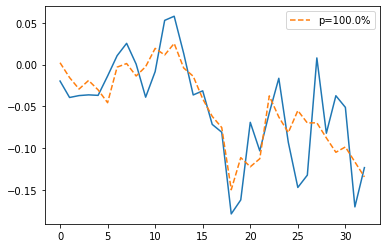

Отрисовать прогноз - несколькими цветами, пунктиром, яркость пропорциональна вероятности
Прогноз итеративный, но синюю линию агент вообще не видит, это Y, а агент видит переменные X, они не показаны


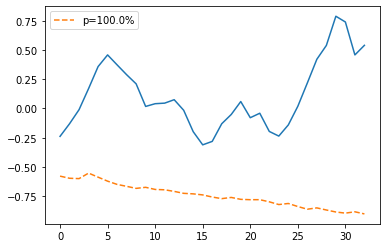

Отрисовать прогноз - несколькими цветами, пунктиром, яркость пропорциональна вероятности
Прогноз итеративный, но синюю линию агент вообще не видит, это Y, а агент видит переменные X, они не показаны


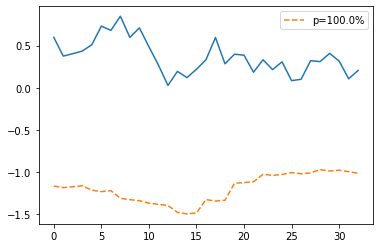

Отрисовать прогноз - несколькими цветами, пунктиром, яркость пропорциональна вероятности
Прогноз итеративный, но синюю линию агент вообще не видит, это Y, а агент видит переменные X, они не показаны


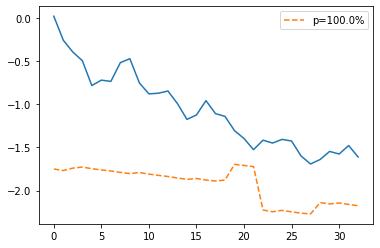

Отрисовать прогноз - несколькими цветами, пунктиром, яркость пропорциональна вероятности
Прогноз итеративный, но синюю линию агент вообще не видит, это Y, а агент видит переменные X, они не показаны


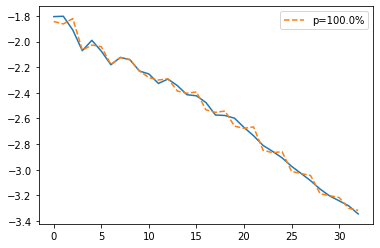

Отрисовать прогноз - несколькими цветами, пунктиром, яркость пропорциональна вероятности
Прогноз итеративный, но синюю линию агент вообще не видит, это Y, а агент видит переменные X, они не показаны


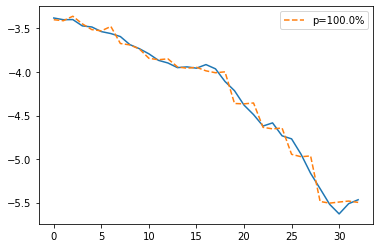

Отрисовать прогноз - несколькими цветами, пунктиром, яркость пропорциональна вероятности
Прогноз итеративный, но синюю линию агент вообще не видит, это Y, а агент видит переменные X, они не показаны


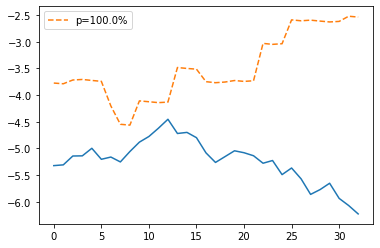

Отрисовать прогноз - несколькими цветами, пунктиром, яркость пропорциональна вероятности
Прогноз итеративный, но синюю линию агент вообще не видит, это Y, а агент видит переменные X, они не показаны


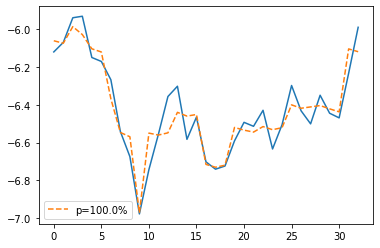

Отрисовать прогноз - несколькими цветами, пунктиром, яркость пропорциональна вероятности
Прогноз итеративный, но синюю линию агент вообще не видит, это Y, а агент видит переменные X, они не показаны


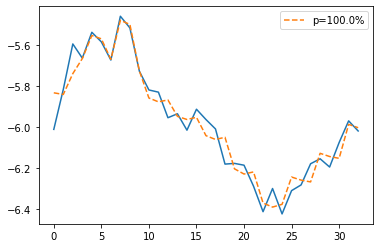

Отрисовать прогноз - несколькими цветами, пунктиром, яркость пропорциональна вероятности
Прогноз итеративный, но синюю линию агент вообще не видит, это Y, а агент видит переменные X, они не показаны


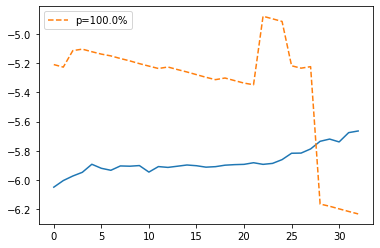

Отрисовать прогноз - несколькими цветами, пунктиром, яркость пропорциональна вероятности
Прогноз итеративный, но синюю линию агент вообще не видит, это Y, а агент видит переменные X, они не показаны


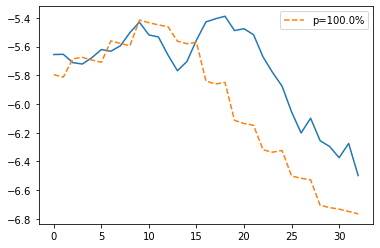

Отрисовать прогноз - несколькими цветами, пунктиром, яркость пропорциональна вероятности
Прогноз итеративный, но синюю линию агент вообще не видит, это Y, а агент видит переменные X, они не показаны


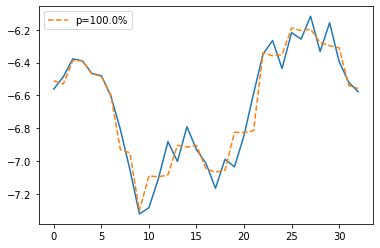

Отрисовать прогноз - несколькими цветами, пунктиром, яркость пропорциональна вероятности
Прогноз итеративный, но синюю линию агент вообще не видит, это Y, а агент видит переменные X, они не показаны


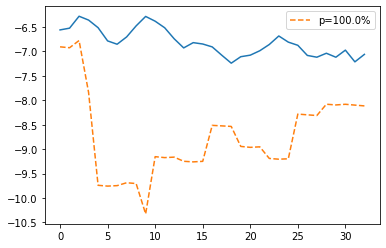

Отрисовать прогноз - несколькими цветами, пунктиром, яркость пропорциональна вероятности
Прогноз итеративный, но синюю линию агент вообще не видит, это Y, а агент видит переменные X, они не показаны


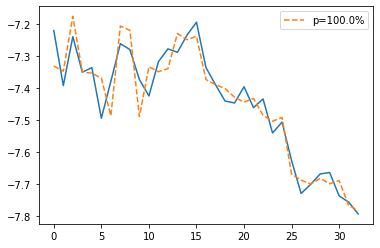

Отрисовать прогноз - несколькими цветами, пунктиром, яркость пропорциональна вероятности
Прогноз итеративный, но синюю линию агент вообще не видит, это Y, а агент видит переменные X, они не показаны


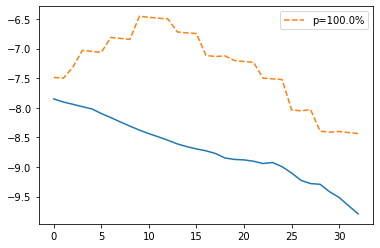

In [11]:
#train
#отрисовать факт синим
#Y_pred = model.predict(X_train,return_hist=True)
for episod in episodes_train:
    #мы учили систему выдавать последовательности длиной в 500/4, на более длинных система работать не обязана, 
    #так что тестим на последовательностях той же длины
    plt.plot(Y_train[episod[0]:episod[1],:])
    Y_pred = model.predict(X_train[episod[0]:episod[1],:],return_hist=True)
    [pred,p_array,m_pred] = Y_pred
    print('Отрисовать прогноз - несколькими цветами, пунктиром, яркость пропорциональна вероятности')
    print('Прогноз итеративный, но синюю линию агент вообще не видит, это Y, а агент видит переменные X, они не показаны')
    for i in range(len(pred)):
        if 15+np.log(p_array[i])>0:
            plt.plot(pred[i],'--',linewidth=0.1*np.max([15+np.log(p_array[i]),0] ), label=f'p={np.round(p_array[i], 6) * 100}%' )
    plt.legend()
    plt.show()

Отрисовать прогноз - несколькими цветами, пунктиром, яркость пропорциональна вероятности
Прогноз итеративный, но синюю линию агент вообще не видит, это Y, а агент видит переменные X, они не показаны


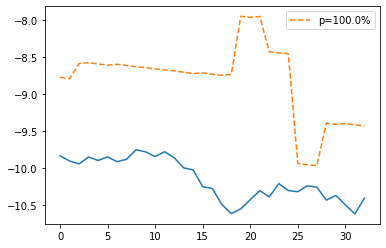

Отрисовать прогноз - несколькими цветами, пунктиром, яркость пропорциональна вероятности
Прогноз итеративный, но синюю линию агент вообще не видит, это Y, а агент видит переменные X, они не показаны


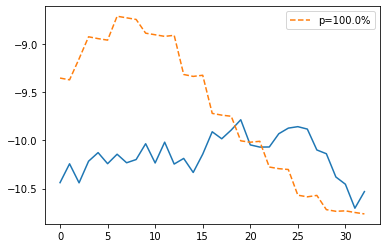

Отрисовать прогноз - несколькими цветами, пунктиром, яркость пропорциональна вероятности
Прогноз итеративный, но синюю линию агент вообще не видит, это Y, а агент видит переменные X, они не показаны


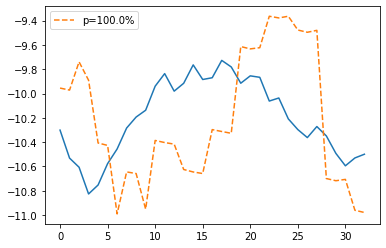

Отрисовать прогноз - несколькими цветами, пунктиром, яркость пропорциональна вероятности
Прогноз итеративный, но синюю линию агент вообще не видит, это Y, а агент видит переменные X, они не показаны


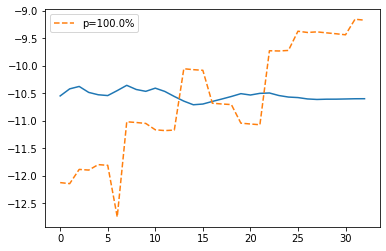

Отрисовать прогноз - несколькими цветами, пунктиром, яркость пропорциональна вероятности
Прогноз итеративный, но синюю линию агент вообще не видит, это Y, а агент видит переменные X, они не показаны


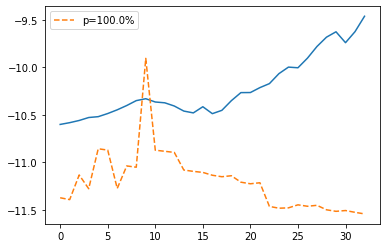

Отрисовать прогноз - несколькими цветами, пунктиром, яркость пропорциональна вероятности
Прогноз итеративный, но синюю линию агент вообще не видит, это Y, а агент видит переменные X, они не показаны


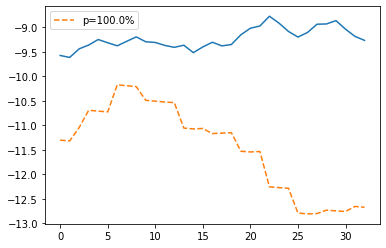

Отрисовать прогноз - несколькими цветами, пунктиром, яркость пропорциональна вероятности
Прогноз итеративный, но синюю линию агент вообще не видит, это Y, а агент видит переменные X, они не показаны


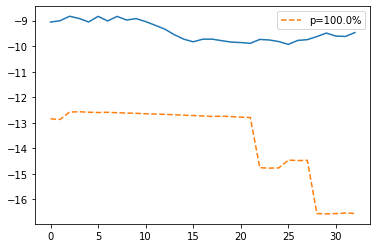

Отрисовать прогноз - несколькими цветами, пунктиром, яркость пропорциональна вероятности
Прогноз итеративный, но синюю линию агент вообще не видит, это Y, а агент видит переменные X, они не показаны


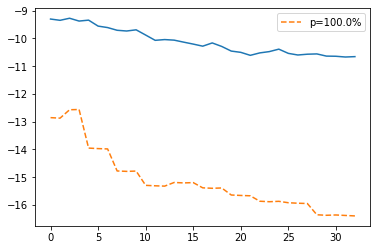

Отрисовать прогноз - несколькими цветами, пунктиром, яркость пропорциональна вероятности
Прогноз итеративный, но синюю линию агент вообще не видит, это Y, а агент видит переменные X, они не показаны


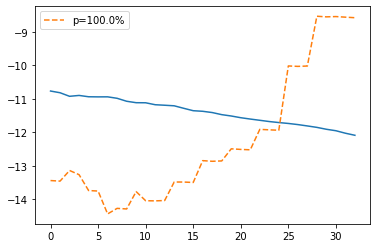

Отрисовать прогноз - несколькими цветами, пунктиром, яркость пропорциональна вероятности
Прогноз итеративный, но синюю линию агент вообще не видит, это Y, а агент видит переменные X, они не показаны


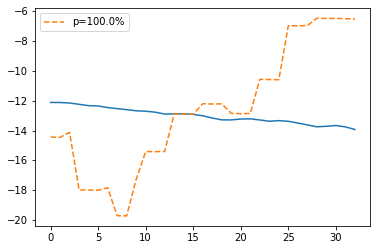

Отрисовать прогноз - несколькими цветами, пунктиром, яркость пропорциональна вероятности
Прогноз итеративный, но синюю линию агент вообще не видит, это Y, а агент видит переменные X, они не показаны


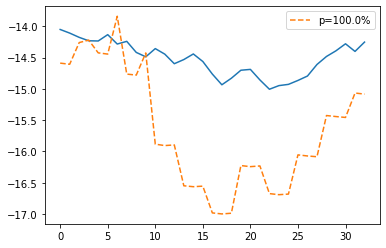

Отрисовать прогноз - несколькими цветами, пунктиром, яркость пропорциональна вероятности
Прогноз итеративный, но синюю линию агент вообще не видит, это Y, а агент видит переменные X, они не показаны


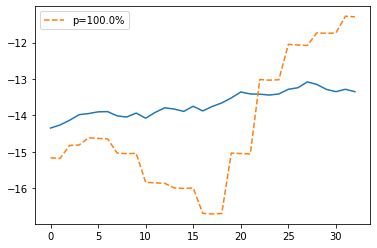

Отрисовать прогноз - несколькими цветами, пунктиром, яркость пропорциональна вероятности
Прогноз итеративный, но синюю линию агент вообще не видит, это Y, а агент видит переменные X, они не показаны


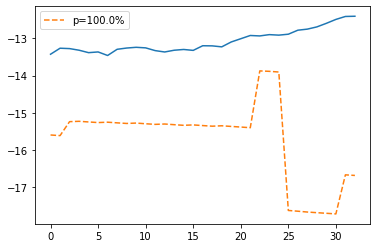

Отрисовать прогноз - несколькими цветами, пунктиром, яркость пропорциональна вероятности
Прогноз итеративный, но синюю линию агент вообще не видит, это Y, а агент видит переменные X, они не показаны


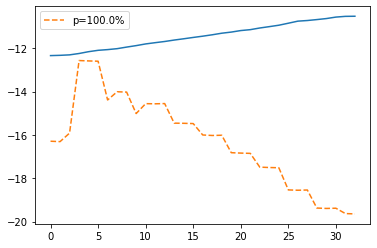

Отрисовать прогноз - несколькими цветами, пунктиром, яркость пропорциональна вероятности
Прогноз итеративный, но синюю линию агент вообще не видит, это Y, а агент видит переменные X, они не показаны


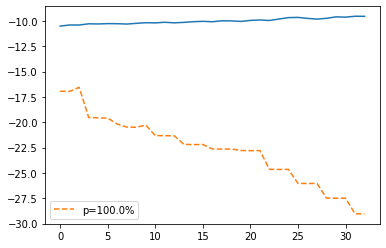

In [12]:
#test
#отрисовать факт синим
#Y_pred = model.predict(X_train,return_hist=True)
for episod in episodes_test:
    #мы учили систему выдавать последовательности длиной в 500/3, на более длинных система работать не обязана, 
    #так что тестим на последовательностях той же длины
    plt.plot(Y_test[episod[0]:episod[1],:])
    Y_pred = model.predict(X_test[episod[0]:episod[1],:],return_hist=True)
    [pred,p_array,m_pred] = Y_pred
    print('Отрисовать прогноз - несколькими цветами, пунктиром, яркость пропорциональна вероятности')
    print('Прогноз итеративный, но синюю линию агент вообще не видит, это Y, а агент видит переменные X, они не показаны')
    for i in range(len(pred)):
        if 15+np.log(p_array[i])>0:
            plt.plot(pred[i],'--',linewidth=0.1*np.max([15+np.log(p_array[i]),0] ), label=f'p={np.round(p_array[i], 6) * 100}%' )
    plt.legend()
    plt.show()

No handles with labels found to put in legend.


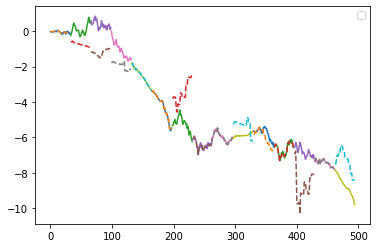

In [15]:
#Нарисовать прогноз всего ряда ЦЕЛИКОМ
for episod in episodes:
    #мы учили систему выдавать последовательности длиной в 500/4, на более длинных система работать не обязана, 
    #так что тестим на последовательностях той же длины
    plt.plot(np.arange(episod[0],episod[1]),Y[episod[0]:episod[1],:])
    Y_pred = model.predict(X[episod[0]:episod[1],:],return_hist=True)
    [pred,p_array,m_pred] = Y_pred
    for i in range(len(pred)):
        if 15+np.log(p_array[i])>0:
            plt.plot(np.arange(episod[0],episod[1]),pred[i],'--',linewidth=0.1*np.max([15+np.log(p_array[i]),0] ))
    #plt.legend()
    #plt.show()
    

plt.legend()
plt.show()

In [22]:
episodes

[[0, 33],
 [33, 66],
 [66, 99],
 [99, 132],
 [132, 165],
 [165, 198],
 [198, 231],
 [231, 264],
 [264, 297],
 [297, 330],
 [330, 363],
 [363, 396],
 [396, 429],
 [429, 462],
 [462, 495]]

In [14]:
1/0

ZeroDivisionError: division by zero

In [ ]:
#делаем датасет
#Суть датасета: есть рандомные массивы, надо найти максимум
X_lst = []
Y_lst = []
for i in range(1000):
    X_rec = np.random.rand(6)*20
    Y_rec = [np.max(X_rec)]
    X_lst.append(X_rec)
    Y_lst.append(Y_rec)
X = np.array(X_lst)
Y = np.array(Y_lst,ndmin=2)

In [ ]:
plt.plot(Y)

In [ ]:
border = 500
X_train = X[:border,:]
X_test = X[border:,:]
Y_train = Y[:border,:]
Y_test = Y[border:,:]

In [ ]:
%%time
model = symbolic_regression_multyboosting(size_genom=900,tact_count=50, regularization=1.)
episodes=[]
for i in range(len(Y_train)-1):
    episodes.append([i,i+1])
model = symbolic_regression_multyboosting(size_genom=900,tact_count=30, regularization=1.)
model.fit(X_train,Y_train,forest_count=9,sample_part=0.8,episodes=episodes,popsize=30, maxiter=3, boosting_count=2, alpha_count=5, elitarism=2, mutation_p=0.02)

In [ ]:
#train
#отрисовать факт синим
for episod in episodes[:20]:
    #мы учили систему выдавать последовательности длиной в 1, на более длинных система работать не обязана, 
    #так что тестим на последовательностях той же длины
    plt.plot(Y_train[episod[0]:episod[1],:])
    Y_pred = model.predict(X_train[episod[0]:episod[1],:],return_hist=True)
    [pred,p_array,m_pred] = Y_pred
    for i in range(len(pred)):
        #отрисовать прогноз - несколькими цветами, пунктиром, яркость пропорциональна вероятности
        if 10+np.log(p_array[i])>0:
            plt.plot(pred[i],'--',linewidth=0.1*np.max([10+np.log(p_array[i]),0] ) )
    plt.show()

In [ ]:
#test
#отрисовать факт
counter = 0
lst = []
for episod in episodes:
    counter += 1
    #мы учили систему выдавать последовательности длиной в 1, на более длинных система работать не обязана, 
    #так что тестим на последовательностях той же длины
    draw = counter<10
    if draw:
        plt.plot(Y_test[episod[0]:episod[1],:])
    Y_pred = model.predict(X_test[episod[0]:episod[1],:],return_hist=True)
    [pred,p_array,m_pred] = Y_pred
    if draw:
        for i in range(len(pred)):
            #отрисовать прогноз - несколькими цветами, пунктиром, яркость пропорциональна вероятности
            if 10+np.log(p_array[i])>0:
                plt.plot(pred[i],'--',linewidth=0.1*np.max([10+np.log(p_array[i]),0] ) )
    mae = np.mean(np.abs(m_pred - Y_test[episod[0]:episod[1],:]))
    mae_mean = mae/np.mean(np.abs(Y_test[episod[0]:episod[1],:]))
    lst.append({'mae':mae, 'mae_mean':mae_mean})
    if draw:
        print('mae',mae,'mae_mean',mae_mean)
        plt.show()

In [ ]:
report = pd.DataFrame(lst)
report

In [ ]:
print(report.mae.mean(),report.mae_mean.mean())